In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls

sample_data/


In [3]:
cd /content/drive/MyDrive/PFA/shared/PFA/wlasl-processed

[Errno 2] No such file or directory: '/content/drive/MyDrive/PFA/shared/PFA/wlasl-processed'
/content


In [4]:
ls

sample_data/


### **<font style="color:#112B3C"> Import the Libraries</font>**

We will start by installing and importing the required libraries.

In [5]:
!pip install ez_setup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ez-setup: filename=ez_setup-0.9-py3-none-any.whl size=11015 sha256=34fe218609b5cafa4aa71c18d7ba02848f35e962688d63ca26d57d8a6e2fc584
  Stored in directory: /root/.cache/pip/wheels/f4/78/bd/f88c8eddfd5a8bf2a029e5cd8bc7a9914597002b081a000ffe
Successfully built ez-setup


In [6]:
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
pip install youtube-dl==2020.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 29.3 MB/s 


In [9]:
# import required libraries
import json
import os
import cv2
import pandas as pd
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [10]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

 ### **<font style="color:#112B3C">Load WLAS Dataset</font>**

In [ ]:
cd /content/drive/MyDrive/PFA/shared/PFA/wlasl-processed

/content/drive/.shortcut-targets-by-id/16gMgbmqNvGL7_NDEhCQmSV5JdsLllzfh/PFA/wlasl-processed


In [ ]:
main_path = ''
wlas_df = pd.read_json(main_path + 'WLASL_v0.3.json')

In [ ]:
wlas_df.head()

,gloss,instances
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra..."
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [ ]:
wlas_df.shape

(2000, 2)

### **<font style="color:#112B3C">Extract the available videos list from the dataset</font>**

In [ ]:
cd /content/drive/MyDrive/PFA/shared/PFA/wlasl-processed

/content/drive/.shortcut-targets-by-id/16gMgbmqNvGL7_NDEhCQmSV5JdsLllzfh/PFA/wlasl-processed


In [ ]:
ls

 animation.gif
 features_df.csv
 LRCN_model_structure_plot.png
 missing.txt
 models/
 nslt_1000.json
 nslt_100.json
 nslt_2000.json
 nslt_300.json
 sample.mp4
 __temp__.mp4
 test_videos/
 test_videosbefore_test-Output-SeqLen20.mp4
'test_videoscomputer ASL-Output-SeqLen20.mp4'
 test_videosCOMPUTER-Output-SeqLen20.mp4
 test_videoscomputer_test-Output-SeqLen20.mp4
 test_videoshave_test-Output-SeqLen20.mp4
 test_videoshello_test-Output-SeqLen20.mp4
'test_videoswake-before funeral ASL-Output-SeqLen20.mp4'
 tmp/
 videos/
 WLASL_v0.3.json


### **<font style="color:#112B3C">Extract the available videos list from the dataset</font>**

In [ ]:
def get_videos_ids(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids of the current instance
    
    input: instance json list
    output: list of videos_ids
    
    """
    videos_list = []    
    for ins in json_list:
        video_id = ins['video_id']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_list.append(video_id)
    return videos_list

In [ ]:
def get_json_features(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids and url or any other featrue of the current instance
    
    input: instance json list
    output: list of videos_ids
    
    """
    videos_ids = []
    videos_urls = []
    split_urls = []
    for ins in json_list:
        video_id = ins['video_id']
        video_url = ins['url']
        split = ins['split']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_ids.append(video_id)
            videos_urls.append(video_url)
            split_urls.append(split)
    return videos_ids, videos_urls, split_urls

In [ ]:
with open(main_path+'WLASL_v0.3.json', 'r') as data_file:
    json_data = data_file.read()

instance_json = json.loads(json_data)

In [ ]:
get_videos_ids(instance_json[0]['instances'])[0]

'07069'

In [ ]:
len(get_videos_ids(instance_json[0]['instances']))

5

In [ ]:
wlas_df['videos_ids'] = wlas_df['instances'].apply(get_videos_ids)

In [ ]:
features_df = pd.DataFrame(columns=['gloss', 'video_id', 'url', 'split'])
for row in wlas_df.iterrows():
#     print(row[1][1])
    ids, urls, split = get_json_features(row[1][1])
    word = [row[1][0]] * len(ids)
    df = pd.DataFrame(list(zip(word, ids, urls, split)), columns = features_df.columns)
    features_df = features_df.append(df, ignore_index=True)

In [ ]:

features_df.index.name = 'index'
features_df

,gloss,video_id,url,split
index,,,,
0,book,07069,https://signstock.blob.core.windows.net/signsc...,train
1,book,07068,https://s3-us-west-1.amazonaws.com/files.start...,train
2,book,07070,https://media.asldeafined.com/vocabulary/14666...,train
3,book,07099,http://www.aslsearch.com/signs/videos/book.mp4,val
4,book,07074,https://www.signingsavvy.com/signs/mp4/14/1432...,train
...,...,...,...,...
7286,propaganda,44962,https://www.signingsavvy.com/signs/mp4/9/9962.mp4,train
7287,proper,44970,https://media.spreadthesign.com/video/mp4/13/3...,val
7288,proper,44971,https://media.asldeafined.com/vocabulary/14687...,train


In [ ]:
# save to csv
#features_df.to_csv('features_df.csv', index=False)

In [ ]:
#features_df = pd.read_csv("features_df.csv")

In [ ]:
cd /content/drive/MyDrive/PFA/shared/PFA/wlasl-processed

/content/drive/.shortcut-targets-by-id/16gMgbmqNvGL7_NDEhCQmSV5JdsLllzfh/PFA/wlasl-processed


In [ ]:
ls

 animation.gif
 features_df.csv
 LRCN_model_structure_plot.png
 missing.txt
 models/
 nslt_1000.json
 nslt_100.json
 nslt_2000.json
 nslt_300.json
 sample.mp4
 __temp__.mp4
 test_videos/
 test_videosbefore_test-Output-SeqLen20.mp4
'test_videoscomputer ASL-Output-SeqLen20.mp4'
 test_videosCOMPUTER-Output-SeqLen20.mp4
 test_videoscomputer_test-Output-SeqLen20.mp4
 test_videoshave_test-Output-SeqLen20.mp4
 test_videoshello_test-Output-SeqLen20.mp4
'test_videoswake-before funeral ASL-Output-SeqLen20.mp4'
 tmp/
 videos/
 WLASL_v0.3.json


In [ ]:
features_df.index.name = 'index'
features_df

,gloss,video_id,url,split
index,,,,
0,book,07069,https://signstock.blob.core.windows.net/signsc...,train
1,book,07068,https://s3-us-west-1.amazonaws.com/files.start...,train
2,book,07070,https://media.asldeafined.com/vocabulary/14666...,train
3,book,07099,http://www.aslsearch.com/signs/videos/book.mp4,val
4,book,07074,https://www.signingsavvy.com/signs/mp4/14/1432...,train
...,...,...,...,...
7286,propaganda,44962,https://www.signingsavvy.com/signs/mp4/9/9962.mp4,train
7287,proper,44970,https://media.spreadthesign.com/video/mp4/13/3...,val
7288,proper,44971,https://media.asldeafined.com/vocabulary/14687...,train


In [ ]:
features_df[features_df['gloss'] == "computer"]

,gloss,video_id,url,split
index,,,,
17,computer,12328,https://www.signingsavvy.com/signs/mp4/6/6326.mp4,train
18,computer,12312,https://s3-us-west-1.amazonaws.com/files.start...,val
19,computer,12311,https://media.spreadthesign.com/video/mp4/13/5...,train
20,computer,12338,http://www.aslsearch.com/signs/videos/computer...,train
21,computer,12313,https://s3-us-west-1.amazonaws.com/files.start...,train
22,computer,12314,https://signstock.blob.core.windows.net/signsc...,train
23,computer,12315,https://signstock.blob.core.windows.net/signsc...,val
24,computer,12316,https://signstock.blob.core.windows.net/signsc...,train
25,computer,12317,https://signstock.blob.core.windows.net/signsc...,train


### **<font style="color:#205375">Visualize the Data with its Labels</font>**

In [ ]:
features_df

,gloss,video_id,url,split
index,,,,
0,book,07069,https://signstock.blob.core.windows.net/signsc...,train
1,book,07068,https://s3-us-west-1.amazonaws.com/files.start...,train
2,book,07070,https://media.asldeafined.com/vocabulary/14666...,train
3,book,07099,http://www.aslsearch.com/signs/videos/book.mp4,val
4,book,07074,https://www.signingsavvy.com/signs/mp4/14/1432...,train
...,...,...,...,...
7286,propaganda,44962,https://www.signingsavvy.com/signs/mp4/9/9962.mp4,train
7287,proper,44970,https://media.spreadthesign.com/video/mp4/13/3...,val
7288,proper,44971,https://media.asldeafined.com/vocabulary/14687...,train


In [ ]:
N = 4
TOP_N_CLASSES = list(features_df.gloss.value_counts().head(N).index)

In [ ]:
TOP_N_CLASSES

['before', 'computer', 'cool', 'go']

In [ ]:
# get all categories classes
all_classes = features_df.gloss.value_counts().keys().to_list()
all_classes

['before',
 'computer',
 'cool',
 'go',
 'cousin',
 'accident',
 'drink',
 'change',
 'cold',
 'delay',
 'last',
 'bowling',
 'bar',
 'later',
 'check',
 'laugh',
 'bed',
 'letter',
 'play',
 'call',
 'pizza',
 'far',
 'champion',
 'help',
 'leave',
 'candy',
 'deaf',
 'interest',
 'hear',
 'basketball',
 'fault',
 'environment',
 'full',
 'move',
 'near',
 'government',
 'ago',
 'daughter',
 'brother',
 'past',
 'cry',
 'argue',
 'delicious',
 'balance',
 'perspective',
 'lose',
 'appointment',
 'give',
 'fat',
 'make',
 'outside',
 'dark',
 'corn',
 'hot',
 'like',
 'graduate',
 'many',
 'fine',
 'family',
 'no',
 'form',
 'onion',
 'necklace',
 'her',
 'australia',
 'list',
 'california',
 'happy',
 'mother',
 'point',
 'good',
 'alone',
 'postpone',
 'humble',
 'example',
 'now',
 'problem',
 'grammar',
 'approve',
 'improve',
 'heart',
 'child',
 'party',
 'choose',
 'crash',
 'country',
 'convince',
 'close',
 'practice',
 'president',
 'jealous',
 'chat',
 'order',
 'expensive',

In [ ]:
classes_dict = {}
for i in range(len(all_classes)):
    classes_dict[all_classes[i]] = i

classes_dict

{'before': 0,
 'computer': 1,
 'cool': 2,
 'go': 3,
 'cousin': 4,
 'accident': 5,
 'drink': 6,
 'change': 7,
 'cold': 8,
 'delay': 9,
 'last': 10,
 'bowling': 11,
 'bar': 12,
 'later': 13,
 'check': 14,
 'laugh': 15,
 'bed': 16,
 'letter': 17,
 'play': 18,
 'call': 19,
 'pizza': 20,
 'far': 21,
 'champion': 22,
 'help': 23,
 'leave': 24,
 'candy': 25,
 'deaf': 26,
 'interest': 27,
 'hear': 28,
 'basketball': 29,
 'fault': 30,
 'environment': 31,
 'full': 32,
 'move': 33,
 'near': 34,
 'government': 35,
 'ago': 36,
 'daughter': 37,
 'brother': 38,
 'past': 39,
 'cry': 40,
 'argue': 41,
 'delicious': 42,
 'balance': 43,
 'perspective': 44,
 'lose': 45,
 'appointment': 46,
 'give': 47,
 'fat': 48,
 'make': 49,
 'outside': 50,
 'dark': 51,
 'corn': 52,
 'hot': 53,
 'like': 54,
 'graduate': 55,
 'many': 56,
 'fine': 57,
 'family': 58,
 'no': 59,
 'form': 60,
 'onion': 61,
 'necklace': 62,
 'her': 63,
 'australia': 64,
 'list': 65,
 'california': 66,
 'happy': 67,
 'mother': 68,
 'point': 69

In [ ]:
features_df['gloss_indx'] = features_df.gloss.map(classes_dict)

In [ ]:
features_df

,gloss,video_id,url,split,gloss_indx
index,,,,,
0,book,07069,https://signstock.blob.core.windows.net/signsc...,train,727
1,book,07068,https://s3-us-west-1.amazonaws.com/files.start...,train,727
2,book,07070,https://media.asldeafined.com/vocabulary/14666...,train,727
3,book,07099,http://www.aslsearch.com/signs/videos/book.mp4,val,727
4,book,07074,https://www.signingsavvy.com/signs/mp4/14/1432...,train,727
...,...,...,...,...,...
7286,propaganda,44962,https://www.signingsavvy.com/signs/mp4/9/9962.mp4,train,1349
7287,proper,44970,https://media.spreadthesign.com/video/mp4/13/3...,val,1171
7288,proper,44971,https://media.asldeafined.com/vocabulary/14687...,train,1171


> *let's initialize some constants*

In [ ]:
ls

 animation.gif
 features_df.csv
 LRCN_model_structure_plot.png
 missing.txt
 models/
 nslt_1000.json
 nslt_100.json
 nslt_2000.json
 nslt_300.json
 sample.mp4
 __temp__.mp4
 test_videos/
 test_videosbefore_test-Output-SeqLen20.mp4
'test_videoscomputer ASL-Output-SeqLen20.mp4'
 test_videosCOMPUTER-Output-SeqLen20.mp4
 test_videoscomputer_test-Output-SeqLen20.mp4
 test_videoshave_test-Output-SeqLen20.mp4
 test_videoshello_test-Output-SeqLen20.mp4
'test_videoswake-before funeral ASL-Output-SeqLen20.mp4'
 tmp/
 videos/
 WLASL_v0.3.json


In [ ]:
# Specify the hight and width each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the dataset.
DATASET_DIR = "videos/"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = all_classes

**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

In [ ]:
def get_index_of_video(vd_id):
    i = 0
    for item in features_df["video_id"]:
        if item == vd_id:
            break
        i = i+1
    return i

In [ ]:
def get_index_of_video(vd_id):
  return features_df['video_id'].loc[lambda x: x==vd_id].index[0]

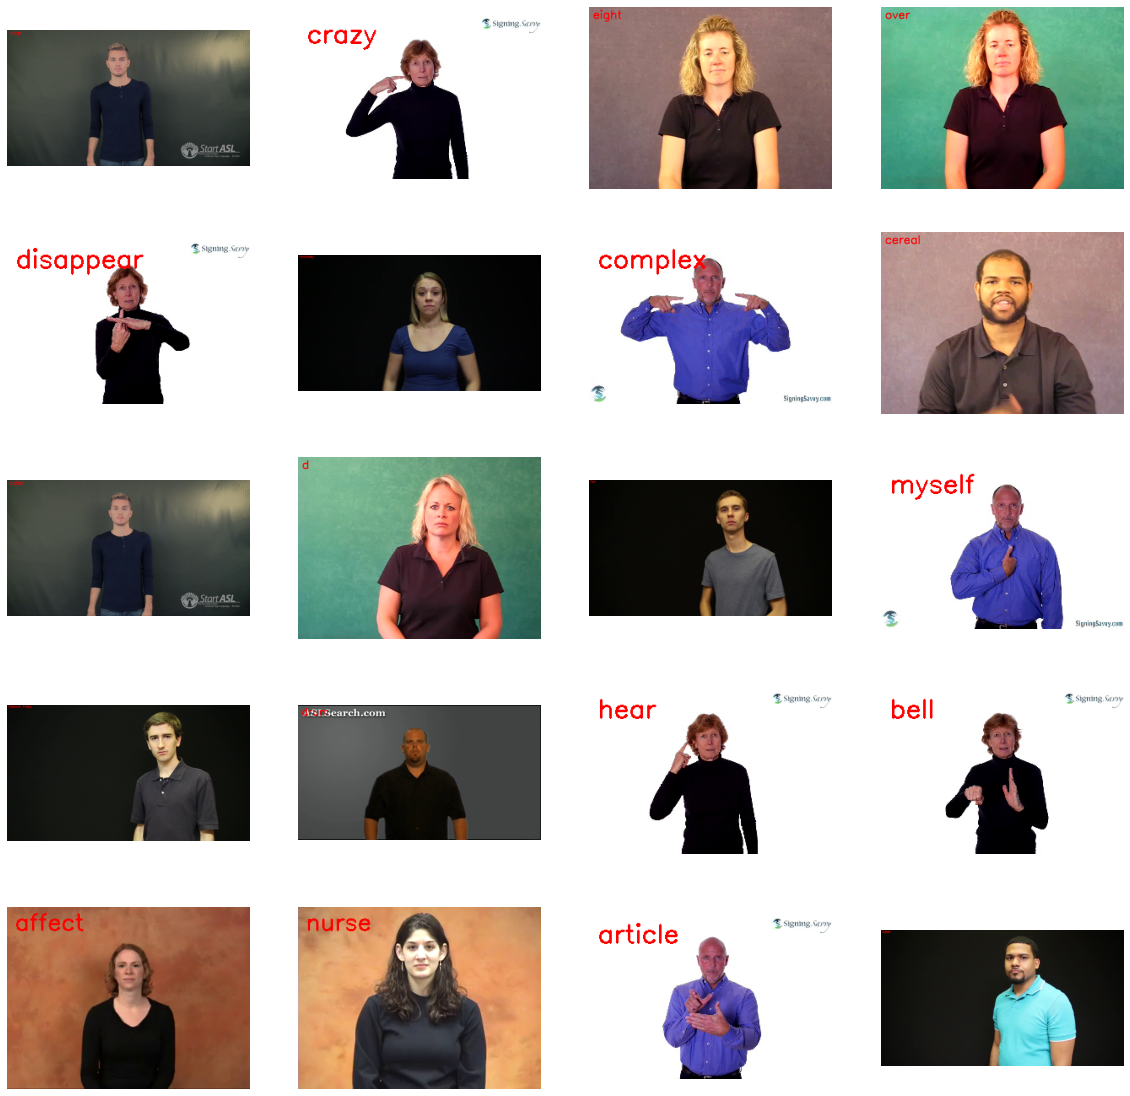

In [ ]:
# Create a Matplotlib figure and specify the size of the figure
plt.figure(figsize=(20, 20))

# Get the names of all classes/categories in UCF50
all_classes_names = os.listdir(DATASET_DIR)

# generate a list of 20 random values. The values will be between 0-50 where 50 is the
# total number of classes in the dataset
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve the list of all the video files present in the randomly selected Class Directory
    video_files_names_list = os.listdir(DATASET_DIR)

    #Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
    
    # Retrieve a Class Name using the Random Index.
    idx = get_index_of_video(selected_video_file_name.split(".")[0])
    selected_class_Name = features_df.iloc[idx].gloss

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{DATASET_DIR}{selected_video_file_name}')

    # Read the first frame of the video file
    _, bgr_frame = video_reader.read()

    # release the video object
    video_reader.release()

    #  convert the frame from VGR into RBG format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Display the frame
    plt.subplot(5, 4, counter); plt.imshow(rgb_frame);plt.axis('off')
   


## **<font style="color:#112B3C">Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

### **<font style="color:#205375">Create a Function to Extract, Resize & Normalize Frames</font>**

We will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames. 

In [ ]:
def frames_extraction(video_path):
    """
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
    video_path: The path of the video in the disk, whose frames are to be extracted.

    Returns:
    frames_list: A list containing the resized and normalized frames of the video.
    """

    # Declare a list to store video frames.
    frames_list = []

    # Read the video File using the videoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
    # Iterate through the Video frames:
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # check if the video frame is not successfully read the break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies wetween 0 and 1
        normalized_frame = resized_frame / 255 

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # return the frames list.
    return frames_list


### **<font style="color:#205375">Create a Function for Dataset Creation</font>**

Now we will create a function **`create_dataset()`** that will iterate through all the video located in the **`DATASET_DIR`** constant and will call the function  **`frame_extraction()`** on every video file and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [ ]:
def create_dataset():
    """
    This function will extract the data of the videos and create the required dataset.
    Retuns:
    features: A list containing the extracted frames of the videos.
    labels :  A list containing the indexes of the classes associated with the video
    video_files_paths :  A list containing the paths of the videos in the disk.
    """

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    split = []
       

    # Get the list of video files present in the specific class name directory.
    files_list = os.listdir(DATASET_DIR)
    count = 0
    for file_name in files_list:

        # Display the name of the video whose data is being extracted and its number in iterations
        

        # Get the complete video path.
        video_file_path = os.path.join(DATASET_DIR, file_name)
        idx = get_index_of_video(file_name.split(".")[0])
        selected_class_Name = features_df.iloc[idx].gloss
        
        if selected_class_Name in TOP_N_CLASSES:
          print(f"Extracting Data of file: {file_name}, number: {count}")
          
          # Extract the frames of the video file.
          frames = frames_extraction(video_file_path)
          #frames = load_rgb_frames_from_video(DATASET_DIR, file_name, 1, SEQUENCE_LENGTH)

          # check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
          # So ignore the videos having less than the SEQUENCE_LENGTH.
          if len(frames) == SEQUENCE_LENGTH:

              # get the video's class name
              class_index = features_df.iloc[idx].gloss_indx
              splt = features_df.iloc[idx].split
              # Append the data to their repective list
              features.append(frames)
              labels.append(class_index)
              video_files_paths.append(video_file_path)
              split.append(splt)
              count = count +1
              

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)
    split = np.asarray(split)

    # Return the frames, class_index and video_file_path
    return features, labels, split

Now we will utilize the function **`create_dataset()`** created above to extract the data and create the required dataset.

In [ ]:
# Creat the dataset
features, labels, split = create_dataset()

Extracting Data of file: 24940.mp4, number: 0
Extracting Data of file: 24973.mp4, number: 1
Extracting Data of file: 24956.mp4, number: 2
Extracting Data of file: 24946.mp4, number: 3
Extracting Data of file: 24955.mp4, number: 4
Extracting Data of file: 24952.mp4, number: 5
Extracting Data of file: 24943.mp4, number: 6
Extracting Data of file: 24962.mp4, number: 7
Extracting Data of file: 24947.mp4, number: 8
Extracting Data of file: 24961.mp4, number: 9
Extracting Data of file: 24960.mp4, number: 10
Extracting Data of file: 24941.mp4, number: 11
Extracting Data of file: 24954.mp4, number: 12
Extracting Data of file: 13196.mp4, number: 13
Extracting Data of file: 13203.mp4, number: 14
Extracting Data of file: 13198.mp4, number: 15
Extracting Data of file: 13197.mp4, number: 16
Extracting Data of file: 12317.mp4, number: 17
Extracting Data of file: 12338.mp4, number: 18
Extracting Data of file: 12318.mp4, number: 19
Extracting Data of file: 12328.mp4, number: 20
Extracting Data of file

## **<font style="color:#112B3C">Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [ ]:
train_data = []
train_labels = []
test_data = []
test_labels = []
for i in range(len(split)):
  if split[i]=="train":
    train_data.append(features[i])
    train_labels.append(labels[i])
  else:
    test_data.append(features[i])
    test_labels.append(labels[i])

train_data = np.asarray(train_data)
train_labels = np.array(train_labels)

test_data = np.asarray(test_data)
test_labels = np.array(test_labels)

In [ ]:
NB_CLASSES = len(set(train_labels))
NB_CLASSES

4

In [ ]:
train_data.shape

(40, 20, 64, 64, 3)

## **<font style="color:#112B3C">CNN Approach</font>**

In [17]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

In [18]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv3D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT, IMAGE_WIDTH, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.MaxPool3D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv3D(filters=10, 
                         kernel_size=3, 
                         activation="relu"
                         ),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(NB_CLASSES, activation="softmax") # binary activation output
])
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 18, 62, 62, 10)    820       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 9, 31, 31, 10)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 29, 29, 10)     2710      
                                                                 
 flatten_1 (Flatten)         (None, 58870)             0         
                                                                 
 dense_3 (Dense)             (None, 4)                 235484    
                                                                 
Total params: 239,014
Trainable params: 239,014
Non-trainable params: 0
________________________________________________

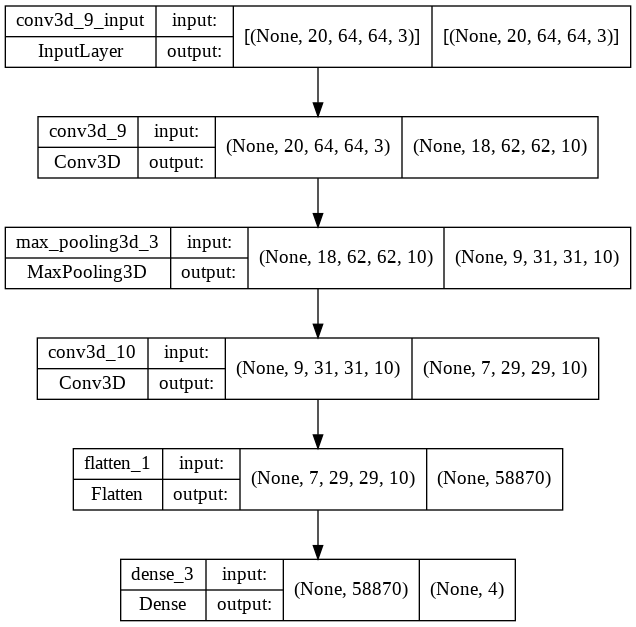

In [19]:
# Plot the structure of the contructed model.
plot_model(model_1, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Compile the model
model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Fit the model
history_1 = model_1.fit(train_data,
                        train_labels,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=(test_data, test_labels),
                        validation_steps=len(test_data))

Epoch 1/20
40/40 [==============================] - 13s 13ms/step - loss: 1.4085 - accuracy: 0.2500 - val_loss: 1.2364 - val_accuracy: 0.3571
Epoch 2/20
40/40 [==============================] - 0s 6ms/step - loss: 0.9790 - accuracy: 0.5750 - val_loss: 1.2067 - val_accuracy: 0.2857
Epoch 3/20
40/40 [==============================] - 0s 6ms/step - loss: 0.5928 - accuracy: 0.8000 - val_loss: 1.4540 - val_accuracy: 0.5000
Epoch 4/20
40/40 [==============================] - 0s 6ms/step - loss: 0.4538 - accuracy: 0.8750 - val_loss: 1.7970 - val_accuracy: 0.5000
Epoch 5/20
40/40 [==============================] - 0s 6ms/step - loss: 0.1313 - accuracy: 0.9750 - val_loss: 1.9988 - val_accuracy: 0.5000
Epoch 6/20
40/40 [==============================] - 0s 5ms/step - loss: 0.0784 - accuracy: 0.9500 - val_loss: 1.9529 - val_accuracy: 0.5000
Epoch 7/20
40/40 [==============================] - 0s 5ms/step - loss: 0.1727 - accuracy: 0.9250 - val_loss: 1.6553 - val_accuracy: 0.5714
Epoch 8/20
40/40 [

In [ ]:
model_1.evaluate(test_data, test_labels)

1/1 [==============================] - 0s 366ms/step - loss: 1.9603 - accuracy: 0.5000


[1.9602936506271362, 0.5]

I see that the model is overfiting, so we may reduce the complexity of the model, remove a CONV layer

In [ ]:
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv3D(filters=32, 
                         kernel_size=3, 
                         activation="relu", 
                         input_shape=(20,64, 64, 3)), 
  tf.keras.layers.Conv3D(64, 3, activation="relu"),
  tf.keras.layers.MaxPool3D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv3D(128, 3, activation="relu"),
  tf.keras.layers.Conv3D(32, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool3D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(NB_CLASSES, activation="softmax") # binary activation output
])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 18, 62, 62, 32)    2624      
                                                                 
 conv3d_3 (Conv3D)           (None, 16, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 8, 30, 30, 64)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 6, 28, 28, 128)    221312    
                                                                 
 conv3d_5 (Conv3D)           (None, 4, 26, 26, 32)     110624    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 2, 13, 13, 32)    0         
 3D)                                                  

In [ ]:
# Compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Fit the model
history_2 = model_2.fit(train_data,
                        train_labels,
                        epochs=40,
                        steps_per_epoch=len(train_data),
                        validation_data=(test_data, test_labels),
                        validation_steps=len(test_data))

Epoch 1/40
40/40 [==============================] - 2s 23ms/step - loss: 1.4396 - accuracy: 0.1750 - val_loss: 1.4093 - val_accuracy: 0.1429
Epoch 2/40
40/40 [==============================] - 1s 19ms/step - loss: 1.3979 - accuracy: 0.2250 - val_loss: 1.3870 - val_accuracy: 0.2143
Epoch 3/40
40/40 [==============================] - 1s 19ms/step - loss: 1.3863 - accuracy: 0.2750 - val_loss: 1.3869 - val_accuracy: 0.2143
Epoch 4/40
40/40 [==============================] - 1s 19ms/step - loss: 1.3865 - accuracy: 0.2750 - val_loss: 1.3870 - val_accuracy: 0.2143
Epoch 5/40
40/40 [==============================] - 1s 19ms/step - loss: 1.3863 - accuracy: 0.2750 - val_loss: 1.3872 - val_accuracy: 0.2143
Epoch 6/40
40/40 [==============================] - 1s 19ms/step - loss: 1.3860 - accuracy: 0.2750 - val_loss: 1.3875 - val_accuracy: 0.2143
Epoch 7/40
40/40 [==============================] - 1s 19ms/step - loss: 1.3860 - accuracy: 0.2750 - val_loss: 1.3877 - val_accuracy: 0.2143
Epoch 8/40
40

In [ ]:
model_2.evaluate(test_data, test_labels)

1/1 [==============================] - 1s 524ms/step - loss: 1.3915 - accuracy: 0.2143


[1.3914719820022583, 0.2142857164144516]

In [12]:
kernel_size = 3
pool_size= 2
first_filters = 128
second_filters = 256
third_filters = 512
first_dense=256
second_dense=128
dropout_conv = 0.3
dropout_dense = 0.2

In [13]:
NB_CLASSES = 4

In [14]:
model3 = Sequential()
# First conv filters
model3.add(Conv3D(first_filters, kernel_size, activation = 'relu', padding="same",
                  input_shape = (20,64, 64, 3)))
model3.add(Conv3D(first_filters, kernel_size, padding="same", activation = 'relu'))
model3.add(Conv3D(first_filters, kernel_size, padding="same", activation = 'relu'))
model3.add(MaxPooling3D(pool_size = pool_size)) 
model3.add(Dropout(dropout_conv))

# Second conv filter
model3.add(Conv3D(second_filters, kernel_size, padding="same", activation ='relu'))
model3.add(Conv3D(second_filters, kernel_size, padding="same", activation ='relu'))
model3.add(Conv3D(second_filters, kernel_size, padding="same", activation ='relu'))
model3.add(MaxPooling3D(pool_size = pool_size))
model3.add(Dropout(dropout_conv))

# Third conv filter
model3.add(Conv3D(third_filters, kernel_size, padding="same", activation ='relu'))
model3.add(Conv3D(third_filters, kernel_size, padding="same", activation ='relu'))
model3.add(Conv3D(third_filters, kernel_size, padding="same", activation ='relu'))
model3.add(MaxPooling3D(pool_size = pool_size))
model3.add(Dropout(dropout_conv))

model3.add(Flatten())

# First dense
model3.add(Dense(first_dense, activation = "relu"))
model3.add(Dropout(dropout_dense))
# Second dense
model3.add(Dense(second_dense, activation = "relu"))
model3.add(Dropout(dropout_dense))

# Out layer
model3.add(Dense(NB_CLASSES, activation = "softmax"))

model3.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
#model3.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 64, 64, 128)   10496     
                                                                 
 conv3d_1 (Conv3D)           (None, 20, 64, 64, 128)   442496    
                                                                 
 conv3d_2 (Conv3D)           (None, 20, 64, 64, 128)   442496    
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 32, 32, 128)  0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 32, 32, 128)   0         
                                                                 
 conv3d_3 (Conv3D)           (None, 10, 32, 32, 256)   884992    
                                                      

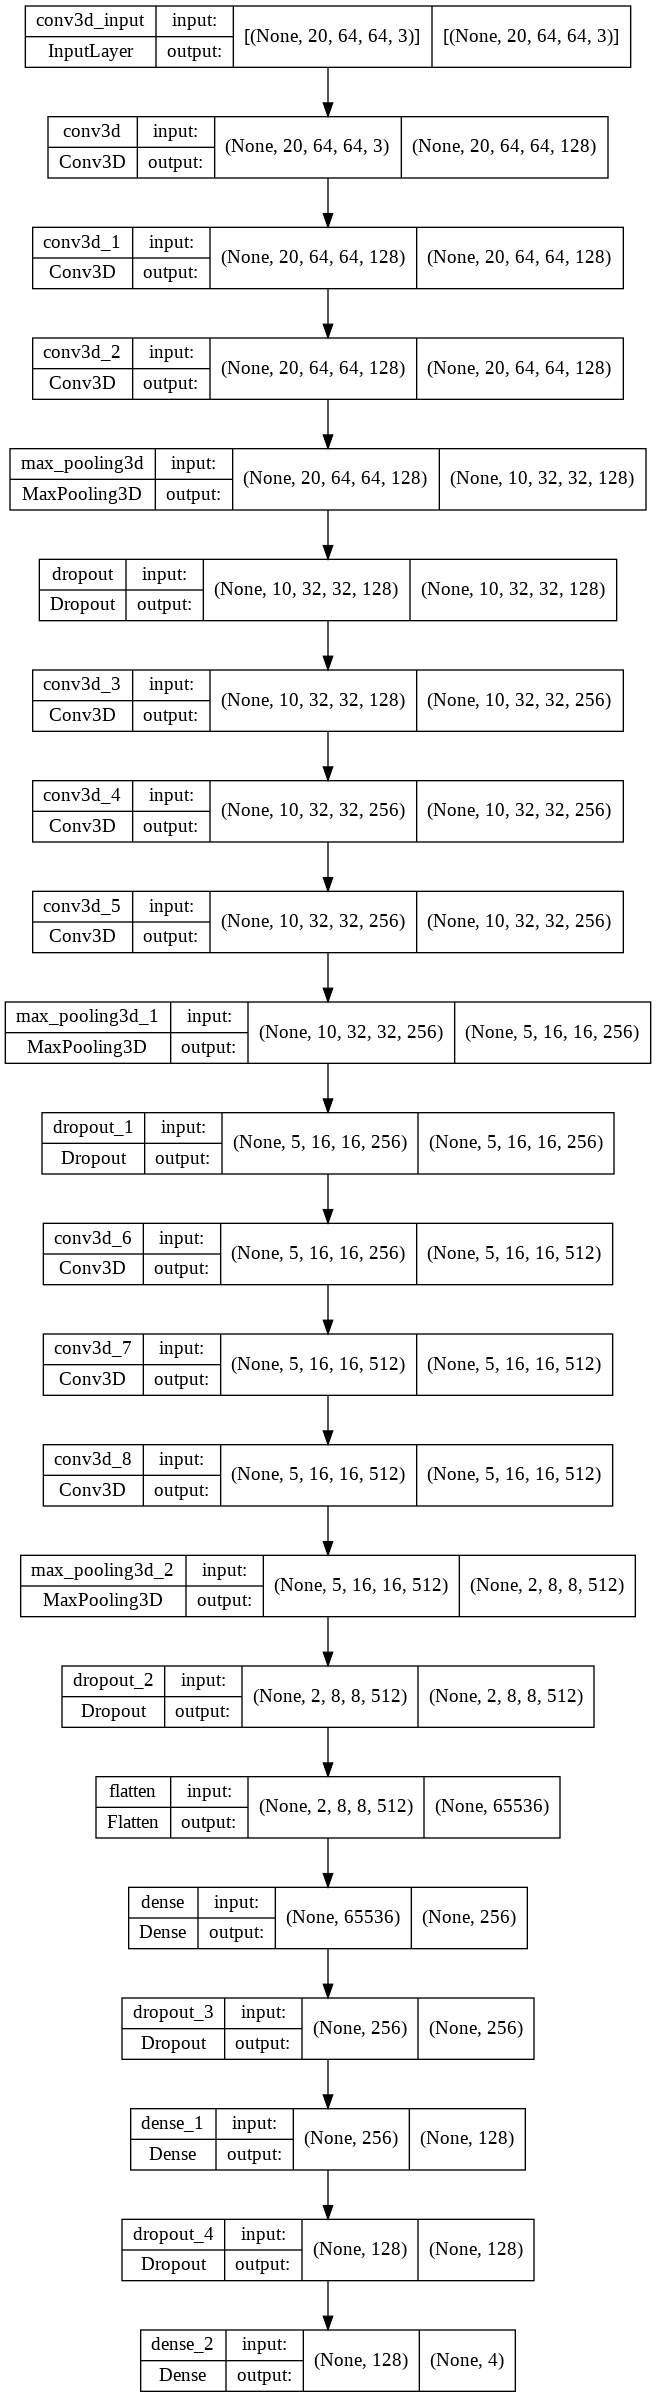

In [15]:
# Plot the structure of the contructed model.
plot_model(model3, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# We'll stop training if no improvement after some epochs
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                            verbose=1, mode='max', min_lr=0.00001)

In [ ]:
# Fit the model
history_3 = model3.fit(train_data,
                        train_labels,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=(test_data, test_labels),
                        validation_steps=len(test_data), callbacks=[earlystopper, reduce_lr])

Epoch 1/20
40/40 [==============================] - 13s 270ms/step - loss: 4.6119 - accuracy: 0.3000 - val_loss: 1.3870 - val_accuracy: 0.2143 - lr: 0.0010
Epoch 2/20
40/40 [==============================] - 11s 265ms/step - loss: 1.3989 - accuracy: 0.1500 - val_loss: 1.3882 - val_accuracy: 0.2143 - lr: 0.0010
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 1.3874 - accuracy: 0.2500
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
40/40 [==============================] - 11s 266ms/step - loss: 1.3874 - accuracy: 0.2500 - val_loss: 1.3877 - val_accuracy: 0.2143 - lr: 0.0010
Epoch 4/20
40/40 [==============================] - 11s 269ms/step - loss: 1.3883 - accuracy: 0.2500 - val_loss: 1.3879 - val_accuracy: 0.2143 - lr: 5.0000e-04
Epoch 5/20
40/40 [==============================] - ETA: 0s - loss: 1.3859 - accuracy: 0.2750
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
40/40 [==============================] - 11

In [ ]:
model3.evaluate(test_data, test_labels)

1/1 [==============================] - 4s 4s/step - loss: 1.3888 - accuracy: 0.2143


[1.388814926147461, 0.2142857164144516]

In [ ]:
model4 = Sequential()

# First conv filters
model4.add(Conv3D(first_filters, kernel_size, activation = 'relu', padding="same",
                  input_shape = (20,64, 64, 3)))
model4.add(Conv3D(first_filters, kernel_size, padding="same", activation = 'relu'))
model4.add(Conv3D(first_filters, kernel_size, padding="same", activation = 'relu'))
model4.add(MaxPooling3D(pool_size = pool_size)) 
model4.add(Dropout(dropout_conv))


model4.add(Flatten())

# First dense
model4.add(Dense(first_dense, activation = "relu"))
model4.add(Dropout(0.8))
# Second dense
model4.add(Dense(second_dense, activation = "relu"))
model4.add(Dropout(0.8))

# Out layer
model4.add(Dense(NB_CLASSES, activation = "softmax"))

model4.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
#model3.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 20, 64, 64, 128)   10496     
                                                                 
 conv3d_16 (Conv3D)          (None, 20, 64, 64, 128)   442496    
                                                                 
 conv3d_17 (Conv3D)          (None, 20, 64, 64, 128)   442496    
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 10, 32, 32, 128)  0         
 3D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 10, 32, 32, 128)   0         
                                                                 
 flatten_3 (Flatten)         (None, 1310720)           0         
                                                      

In [ ]:
# Fit the model
history_4 = model4.fit(train_data,
                        train_labels,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=(test_data, test_labels),
                        validation_steps=len(test_data), callbacks=[earlystopper, reduce_lr])

Epoch 1/20
40/40 [==============================] - 9s 212ms/step - loss: 3.7896 - accuracy: 0.1750 - val_loss: 1.3864 - val_accuracy: 0.2143 - lr: 0.0010
Epoch 2/20
40/40 [==============================] - 8s 207ms/step - loss: 1.3931 - accuracy: 0.2250 - val_loss: 1.3872 - val_accuracy: 0.2143 - lr: 0.0010
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 1.3835 - accuracy: 0.3000
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
40/40 [==============================] - 8s 207ms/step - loss: 1.3835 - accuracy: 0.3000 - val_loss: 1.3865 - val_accuracy: 0.2143 - lr: 0.0010
Epoch 4/20
40/40 [==============================] - 8s 206ms/step - loss: 1.3853 - accuracy: 0.2000 - val_loss: 1.3867 - val_accuracy: 0.2143 - lr: 5.0000e-04
Epoch 5/20
40/40 [==============================] - ETA: 0s - loss: 1.3988 - accuracy: 0.1750
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
40/40 [==============================] - 8s 206

In [ ]:
model4.evaluate(test_data, test_labels)

1/1 [==============================] - 1s 581ms/step - loss: 1.3876 - accuracy: 0.2143


[1.3876111507415771, 0.2142857164144516]

In [ ]:
kernel_size = list(range(3, 20, 2))
pool_size= list(range(2, 10))
drop_size = [i/100 for i in range(10, 100, 5)]
first_filters = 128
second_filters = 256
third_filters = 512
first_dense=256
second_dense=128
dropout_conv = 0.3
dropout_dense = 0.2

In [ ]:
drop_size

[0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

In [ ]:
steps_per_epoch = len(train_data)//20

validation_steps = len(test_data)//20 # if you have validation data 

In [ ]:
hst = list()

for ks in kernel_size:
  for ps in pool_size:
    for ds in drop_size:

      model5 = Sequential()

      # First conv filters
      model5.add(Conv3D(16, ks, activation = 'relu', padding="same",
                        input_shape = (20,64, 64, 3)))
      model5.add(MaxPooling3D(pool_size = ps)) 
      model5.add(Dropout(ds))


      model5.add(Flatten())


      # Out layer
      model5.add(Dense(NB_CLASSES, activation = "softmax"))

      model5.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])
      #model3.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
      #model5.summary()

      # Fit the model
      history_5 = model5.fit(train_data,
                              train_labels,
                              epochs=20,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=(test_data, test_labels), verbose=0 )
      print(history_5.history["val_accuracy"][-1], history_5.history["val_loss"][-1])
      hst.append([ks, ps, ds, history_5.history["val_accuracy"][-1]])

0.4285714328289032 1.4555646181106567
0.4285714328289032 2.0220487117767334
0.3571428656578064 2.157519817352295
0.4285714328289032 1.850645899772644
0.4285714328289032 1.3566703796386719
0.5 1.5664337873458862
0.4285714328289032 2.354573965072632
0.3571428656578064 2.2963054180145264
0.4285714328289032 2.287853240966797
0.4285714328289032 1.6280481815338135
0.3571428656578064 1.8807111978530884
0.3571428656578064 2.5673298835754395
0.4285714328289032 1.55721914768219
0.4285714328289032 1.8957240581512451
0.4285714328289032 1.6450879573822021
0.3571428656578064 1.8074090480804443
0.5 1.884082555770874
0.4285714328289032 1.7997864484786987
0.3571428656578064 1.73032546043396
0.4285714328289032 1.7627357244491577
0.3571428656578064 1.9349801540374756
0.5 1.4753068685531616
0.3571428656578064 1.5200577974319458
0.5 1.7112400531768799
0.4285714328289032 1.936036467552185
0.4285714328289032 1.5003119707107544
0.4285714328289032 1.6958554983139038
0.5 1.4733277559280396
0.4285714328289032 1.

KeyboardInterrupt: ignored

In [ ]:
# Fit the model
history_5 = model5.fit(train_data,
                        train_labels,
                        epochs=20,
                        steps_per_epoch=80,
                        validation_data=(test_data, test_labels),
                        validation_steps=len(test_data), callbacks=[reduce_lr])

In [ ]:
history_5.history

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
#model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
#model_file_name = f'models/convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
model_file_name = f'models/CNN_model1.h5'

# Save your Model.
model_1.save(model_file_name)

### **<font style="color:#205375">Plot Model’s Loss & Accuracy Curves</font>**


Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Now we will utilize the function **`plot_metric()`** created above, to visualize and understand the metrics.

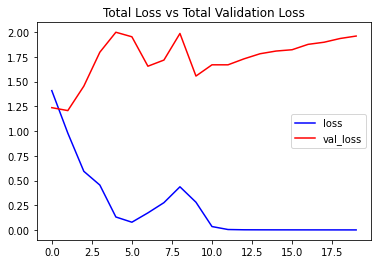

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(history_1, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

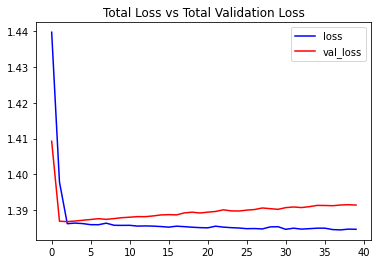

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(history_2, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

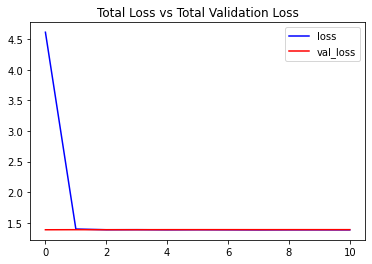

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(history_3, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

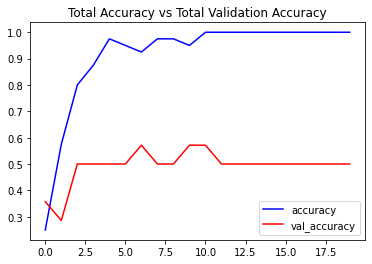

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(history_1, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

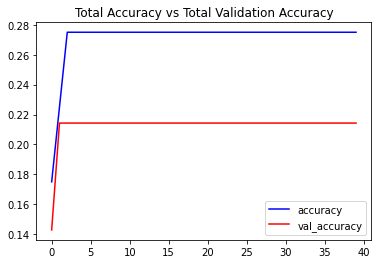

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(history_2, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

### **<font style="color:#205375">Create a Function to Download YouTube Videos:</font>**

We will create a function **`download_youtube_videos()`** to download the YouTube videos first using **`pafy`** library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''
 
     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)
 
     # Retrieve the title of the video.
     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 
     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'
 
     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title

### **<font style="color:#205375">Download a Test Video:</font>**

Now we will utilize the function **`download_youtube_videos()`** created above to download a youtube video on which the `LRCN` model will be tested.

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

In [ ]:
ls

 animation.gif
 features_df.csv
 LRCN_model_structure_plot.png
 missing.txt
 models/
 nslt_1000.json
 nslt_100.json
 nslt_2000.json
 nslt_300.json
 sample.mp4
 __temp__.mp4
 test_videos/
 test_videosbefore_test-Output-SeqLen20.mp4
'test_videoscomputer ASL-Output-SeqLen20.mp4'
 test_videosCOMPUTER-Output-SeqLen20.mp4
 test_videoscomputer_test-Output-SeqLen20.mp4
 test_videoshave_test-Output-SeqLen20.mp4
 test_videoshello_test-Output-SeqLen20.mp4
'test_videoswake-before funeral ASL-Output-SeqLen20.mp4'
 tmp/
 videos/
 WLASL_v0.3.json


In [ ]:
features_df[features_df['gloss'] == "computer"]

,gloss,video_id,url,split,gloss_indx
index,,,,,
17,computer,12328,https://www.signingsavvy.com/signs/mp4/6/6326.mp4,train,1
18,computer,12312,https://s3-us-west-1.amazonaws.com/files.start...,val,1
19,computer,12311,https://media.spreadthesign.com/video/mp4/13/5...,train,1
20,computer,12338,http://www.aslsearch.com/signs/videos/computer...,train,1
21,computer,12313,https://s3-us-west-1.amazonaws.com/files.start...,train,1
22,computer,12314,https://signstock.blob.core.windows.net/signsc...,train,1
23,computer,12315,https://signstock.blob.core.windows.net/signsc...,val,1
24,computer,12316,https://signstock.blob.core.windows.net/signsc...,train,1
25,computer,12317,https://signstock.blob.core.windows.net/signsc...,train,1


In [ ]:
TOP_N_CLASSES

['before', 'computer', 'cool', 'go']

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform ASL on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the ASL is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = model_1.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
input_video_file_path = "videos/12328.mp4"
video_title = "computer_test"

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

In [ ]:
from moviepy.editor import VideoFileClip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3825664/45929032 bytes (8.3%)7569408/45929032 bytes (16.5%)11509760/45929032 bytes (25.1%)15622144/45929032 bytes (34.0%)19726336/45929032 bytes (42.9%)23838720/45929032 bytes (51.9%)27844608/45929032 bytes (60.6%)31956992/45929032 bytes (69.6%)36061184/45929032 bytes (78.5%)40034304/45929032 bytes (87.2%)43982848/45929032 bytes (95.8%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 89/89 [00:00<00:00, 107.23it/s]


In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=ILJfwyR8PP4', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

In [ ]:
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

In [ ]:
# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=bqKb9hkQfQ4', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'


# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
#predict_on_video(f'{DATASET_DIR}/69241.mp4', output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

In [ ]:
features_df[features_df['gloss'] == "before"]

In [ ]:
input_video_file_path = "videos/05728.mp4"
video_title = "before_test"
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

In [ ]:
input_video_file_path = "videos/05743.mp4"
video_title = "before_test"
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

In [ ]:
input_video_file_path = "videos/05732.mp4"
video_title = "before_test"
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

## General Test

In [ ]:


# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=UQtL53JgftI', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'


# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
#predict_on_video(f'{DATASET_DIR}/69241.mp4', output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

Output hidden; open in https://colab.research.google.com to view.